# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

In [1]:
!pip install category_encoders catboost pdpbox eli5

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [0]:
train.to_csv('train.csv')
test.to_csv('test.csv')

In [0]:
train = pd.read_csv('train.csv')
del train['Unnamed: 0']
test  = pd.read_csv('test.csv')
del test['Unnamed: 0']

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._






In [364]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [365]:
train.isna().sum()

Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

In [366]:
list(train.select_dtypes('object').columns)

['DBA Name',
 'AKA Name',
 'Facility Type',
 'Risk',
 'Address',
 'City',
 'State',
 'Inspection Date',
 'Inspection Type',
 'Violations',
 'Location']

In [367]:
train.select_dtypes('object').describe()

,DBA Name,AKA Name,Facility Type,Risk,Address,City,State,Inspection Date,Inspection Type,Violations,Location
count,51916,51293,51692,51904,51916,51863,51906,51916,51915,42261,51718
unique,17049,16350,329,3,13954,39,1,2257,51,42164,13410
top,SUBWAY,SUBWAY,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,2017-03-23T00:00:00,Canvass,45. FOOD HANDLER REQUIREMENTS MET - Comments: ...,"{'longitude': '-87.91442843927047', 'latitude'..."
freq,654,802,34264,37731,741,51659,51906,50,24170,3,741


In [368]:
train.dtypes

Inspection ID        int64
DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Violations          object
Latitude           float64
Longitude          float64
Location            object
Fail                 int64
dtype: object

In [369]:
train['Violations'].mode()

0    33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...
1    38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...
2    38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...
3    38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...
4    45. FOOD HANDLER REQUIREMENTS MET - Comments: ...
5    45. FOOD HANDLER REQUIREMENTS MET - Comments: ...
6    45. FOOD HANDLER REQUIREMENTS MET - Comments: ...
7    45. FOOD HANDLER REQUIREMENTS MET - Comments: ...
dtype: object

In [370]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [371]:
train.isna().sum()

Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

In [372]:
train['Risk'].mode()

0    Risk 1 (High)
dtype: object

In [0]:
# Wrangle function

def wrangle(df):
  
  df = df.copy()
  
  # Drop unndeeded features and violations since it has leakage
  drop = ['AKA Name','Address','Location','Latitude','Longitude','Zip',
          'Inspection ID','Violations']
  df = df.drop(drop,axis=1)
  
  # Get rid of text in Risk and fill with mode
  df['Risk'] = df['Risk'].fillna('666 fill with mode')
  df['Risk'] = df['Risk'].str.extract('(\d+)').astype(int)
  df['Risk'] = df['Risk'].replace(np.NaN, 666)
  df['Risk'] = df['Risk'].fillna(df['Risk'].mode())

  # Change inspection date to int
  df['Inspection Date'] = pd.to_datetime(df['Inspection Date'], infer_datetime_format=True)
  df['Inspection Date'] = df['Inspection Date'].astype('int')
  
  # Encode objects Ordinally but return nan
  import category_encoders as ce
  objects = list(df.select_dtypes('object').columns)
  df[objects] = ce.OrdinalEncoder().fit_transform(df[objects]) 
  
  return df

In [0]:
train = wrangle(train)
test = wrangle(test)

In [421]:
train.shape, test.shape

((51916, 9), (17306, 9))

In [422]:
train.isna().sum()

DBA Name           0
License #          5
Facility Type      0
Risk               0
City               0
State              0
Inspection Date    0
Inspection Type    0
Fail               0
dtype: int64

### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._

In [425]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score

X_train = train.drop('Fail',axis=1)
y_train = train['Fail']
X_test = test.drop('Fail',axis=1)
y_test = test['Fail']

xgb = XGBClassifier(max_depth=4, learning_rate=0.005, n_estimators=200, 
                         silent=True, objective='binary:logistic', booster='gbtree', 
                         n_jobs=-1, nthread=-1, gamma=0, min_child_weight=1, 
                         max_delta_step=0, subsample=1, colsample_bytree=0.5, 
                         colsample_bylevel=1, reg_alpha=2, reg_lambda=3, 
                         scale_pos_weight=1, base_score=0.5, random_state=0, 
                         seed=None, missing=None)

xgb.fit(X_train, y_train)

y_pred_proba = xgb.predict_proba(X_train)[:,1]
print('3-fold ROC AUC on training set:', cross_val_score(ct, X_train, y_train, scoring='roc_auc', cv=3))

3-fold ROC AUC on training set: [0.68328182 0.69246067 0.6946425 ]


In [426]:
from sklearn.metrics import roc_auc_score

y_pred_proba = xgb.predict_proba(X_test)[:,1]
print('Validation of ROC AUC on the test set:', roc_auc_score(y_test, y_pred_proba))

Validation of ROC AUC on the test set: 0.6203264614461571


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

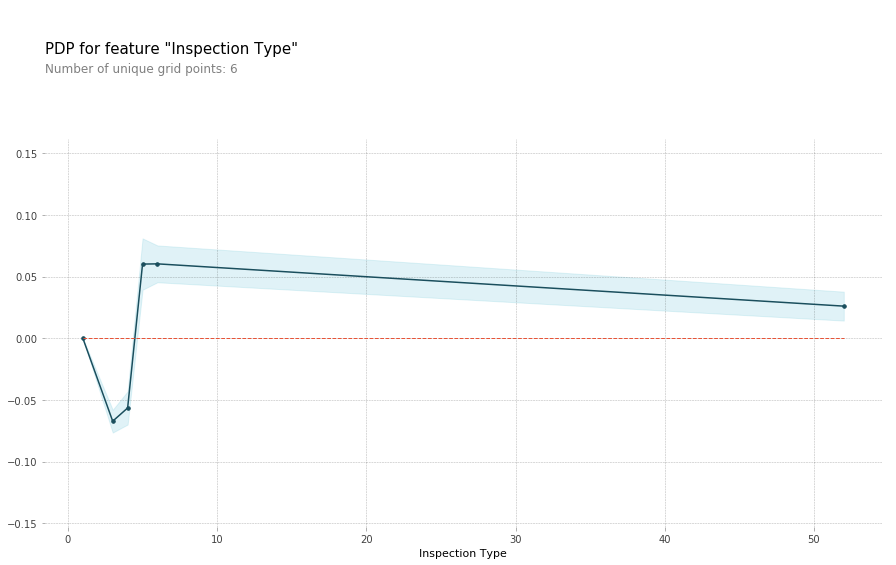

In [437]:
# Partial dependence plot

from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

feature='Inspection Type'
pdp_isolated = pdp_isolate(model=xgb, dataset=X_train,
                           model_features=X_train.columns, feature=feature)
pdp_plot(pdp_isolated, feature);

In [438]:
import eli5
from eli5.sklearn import PermutationImportance

X_train = X_train.fillna(method='bfill')
permuter = PermutationImportance(xgb, scoring='roc_auc', n_iter=1, cv='prefit')
permuter.fit(X_train, y_train)

PermutationImportance(cv='prefit',
           estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.005,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=-1, nthread=-1,
       objective='binary:logistic', random_state=0, reg_alpha=2,
       reg_lambda=3, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
           n_iter=1, random_state=None, refit=True, scoring='roc_auc')

In [439]:
eli5.show_weights(permuter, top=None, feature_names=X_train.columns.tolist())

Weight,Feature
0.1535 ± 0.0000,Inspection Type
0.0220 ± 0.0000,Inspection Date
0.0101 ± 0.0000,License #
0.0036 ± 0.0000,Facility Type
0.0033 ± 0.0000,Risk
0.0020 ± 0.0000,DBA Name
0.0000 ± 0.0000,City
0 ± 0.0000,State
